# Quantization of an already trained FasterKan Model

> **Note:** Before running this notebook, ensure you have already trained a FasterKAN model by executing `mnist_kan_training.py`. This notebook assumes the existence of a pre-trained model checkpoint and its configuration file.

This notebook demonstrates the quantization workflow for an already trained FasterKAN model on the MNIST handwritten digit classification task. The workflow leverages the FasterKAN implementation and custom quantization utilities from the `kan_utils` and `quantization` modules.

## Workflow Overview

1. **Pretrained Float Model Loading**: Load a pre-trained FasterKAN model and its configuration from a checkpoint.
2. **Float Model Validation**: Evaluate the full-precision (FP32) model on the MNIST validation set to establish a baseline.
3. **Quantized Model Construction**: Build a fixed-point (quantized) version of the model and calibrate its quantization parameters using training data.
4. **Quantized Validation**: Validate the quantized model and compare its accuracy to the FP32 baseline.
5. **Model Evaluation** : Compare the classification performance of the FP32 and quantized models using confusion matrices and detailed per-class metrics.

## Settings

Before running this notebook, you can adjust the following settings to customize the experiment.

In [29]:
# Import required libraries
import sys
import os
import torch

# Add the parent directory to sys.path so modules from other directories can be imported
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Import custom modules
from kan_utils.training import validate_model
from kan_utils.fasterkan import FasterKAN
from kan_utils.general_utils import load_json
from kan_utils.checkpoint_utils import load_model_checkpoint, save_model_checkpoint
from kan_utils.mapper import get_criterion, get_optimizer
from kan_utils.plotter import plot_confusion_matrix
from kan_utils.quant_fasterkan import FixedPointFasterKAN, FloatWrapperModule

# Set up autoreload for Jupyter Notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
# CONFIGURATIONS FOR REPRODUCABILITY
device = 'cpu'
RANDOM_SEED = 42

# Set random seeds for reproducibility
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)

In [31]:
# Location of the MNIST dataset 
DATASET_ROOT = './data'

# Location of the pretained FP32 models
PRETRAINED_DICT = 'Training Checkpoints'

# Desired location of the quantized checkpoints
QUANT_DICT = 'Custom-Quantizer'

## 1. Pretrained Float Model Loading

In this section, we will load a pre-trained FasterKAN model and its configuration from a checkpoint directory. This includes reading the model architecture, hyperparameters, and loading the saved weights. These steps ensure that the model is ready for evaluation and quantization, and that all settings match those used during training.

In [32]:
# Load the model path you want to quantize
model_dir = "CrossEntropyLoss_AdamW_ReduceLROnPlateau_0.003_[4]_c4165b3a/"
model_path = PRETRAINED_DICT + '/' + model_dir

# Load the config file and the best checkpoint pth file directory
model_config = os.path.join(model_path, "config.json")
best_checkpoint = os.path.join(model_path, "best/model_checkpoint.pth")

In [33]:
# Load the parameters from the config.json
config = load_json(model_config)

# Model parameters from config
seed = config.get('seed')
criter = config.get('criterion')
optim = config.get('optimizer')
sched = config.get('scheduler')
lr = config.get('learning_rate')
dim_list = config.get('grid_size_per_layer')
grid_size = config.get('grid_size_per_layer')[0] if isinstance(config.get('grid_size_per_layer'), list) else config.get('grid_size_per_layer')
grid_min = config.get('grid_min')
grid_max = config.get('grid_max')
inv_denominator = config.get('inv_denominator')
x_dim = config.get('x_dim')
y_dim = config.get('y_dim')

# # Debug: Print the loaded configuration parameters
# print("Model Configuration Loaded:")
# print(f" - Seed: {seed}")
# print(f" - Criterion: {criter}")
# print(f" - Optimizer: {optim}")
# print(f" - Scheduler: {sched}")
# print(f" - Learning Rate: {lr}")
# print(f" - Dimension List: {dim_list}")
# print(f" - Grid Size: {grid_size}")
# print(f" - Grid Min: {grid_min}")
# print(f" - Grid Max: {grid_max}")
# print(f" - Inverse Denominator: {inv_denominator}")
# print(f" - X Dimension: {x_dim}")
# print(f" - Y Dimension: {y_dim}")

In [34]:
# Build FP32 model from config
fp32_model = FasterKAN(
    layers_hidden=config['dim_list'],
    num_grids=config['grid_size_per_layer'],
    grid_min=config['grid_min'],
    grid_max=config['grid_max'],
    inv_denominator=config['inv_denominator']
).to(device)


# Get criterion and optimizer from config
criter = get_criterion(config["criterion"], {})
optimizer_args = {
    "lr": config["learning_rate"],
    "betas": tuple(config["optimizer_betas"]),
    "weight_decay": config["weight_decay"],
}
optim = get_optimizer(config['optimizer'], fp32_model.parameters(), optimizer_args)

In [35]:
# Load the pretrained weights into the model
fp32_model, _, _, _, _ = load_model_checkpoint(fp32_model, device, best_checkpoint)
fp32_model.eval()

Checkpoint loaded from Training Checkpoints/CrossEntropyLoss_AdamW_ReduceLROnPlateau_0.003_[4]_c4165b3a/best/model_checkpoint.pth. Next epoch is 14.


In [36]:
# DEBUG: Print model state dict keys and values
# for key, value in fp32_model.state_dict().items():
#     print(f"{key}: {value}")

## 2. Float Model Validation
In this section, we will evaluate the accuracy of the pre-trained full-precision (FP32) FasterKAN model on the MNIST validation set. This establishes a baseline performance before quantization.

In [37]:
#  Make a validation loader and validate the model
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Data transformation used on training and config 
training_transform = transforms.Compose([
    transforms.Resize((x_dim, y_dim)),  # Resize to match model input dimensions
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

val_dataset = datasets.MNIST(
    root=DATASET_ROOT,
    train=False,
    download=False,
    transform=training_transform,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=128,
    shuffle=False,
)

In [38]:
# Validate the pretrained FP32 model
val_loss_fp32, val_accuracy_fp32 = validate_model(fp32_model, val_loader, criter, 
                                                  best_checkpoint, optim, device , metrics_flag=True)
print(f"Validation Accuracy of Float Model: {val_accuracy_fp32:.2f}%")

Checkpoint loaded from Training Checkpoints/CrossEntropyLoss_AdamW_ReduceLROnPlateau_0.003_[4]_c4165b3a/best/model_checkpoint.pth. Next epoch is 14.
Model loaded from checkpoint: Training Checkpoints/CrossEntropyLoss_AdamW_ReduceLROnPlateau_0.003_[4]_c4165b3a/best/model_checkpoint.pth


Validating:   0%|          | 0/79 [00:00<?, ?batch/s]

F1 Score: 0.9524
Recall: 0.9525
Accuracy: 95.25%
Confusion Matrix:
[[ 964    0    1    0    0    1    6    1    6    1]
 [   0 1122    3    1    0    1    3    0    5    0]
 [  10    2  993    3    3    0    0    9   11    1]
 [   1    9   10  929    0   23    0   14   15    9]
 [   2    1    1    0  914    2   11    1    0   50]
 [   6    3    0   13    4  855    6    1    2    2]
 [   5    5    0    0    2    6  937    0    3    0]
 [   1   18   14    1    2    0    0  968    1   23]
 [  11    5    5    8    8   16    5    6  893   17]
 [   6    9    0   13   20    1    1    6    3  950]]
Validation Accuracy of Float Model: 95.25%


## 3. Quantized Model Construction: 

In this section, we will construct a quantized (fixed-point) version of the pre-trained FasterKAN model. This involves creating a new model instance using the `FixedPointFasterKAN` class, configuring the quantization parameters (such as bit-width and fractional bits), and calibrating the quantized model using a batch of training data. The goal is to prepare a quantized model that closely matches the behavior of the original full-precision model, enabling efficient inference with reduced memory and computational requirements.

In [39]:
# QUANTIZATION CONFIGURATIONS

# A. Quantization Flags
# HARDTANH: If True, use hardtanh activation function
# FIT_MODEL: If True, fit the quantization ranges using calibration loader
HARDTANH = False
FIT_MODEL = True 

# B. Quantization Dictionaries
# dtype_dict = { 'param_name': (num_bits, is_signed), ... }
# frac_bits_dict = { 'param_name': num_frac_bits, ... }

# B.1. int8 (8 bits) quantization config
num_bits = 8
dtype_dict = {
    'grid':   (num_bits, False),
    'scale':  (num_bits, False),
    'weight': (num_bits, False),
    'sdff':   (num_bits, False),
    'actf':   (num_bits - 1, True),  # 7 bits, signed
    'result': (num_bits, False),
}
frac_bits_dict = {
    'grid': 4,
    'scale': 4,
    'weight': 4,
    'sdff': 4,
    'actf': 7,
    'result': 4,
}

# B.2. int16 (16 bits) quantization config
# num_bits = 16
# dtype_dict = {
#     'grid':   (num_bits, False),
#     'scale':  (num_bits, False),
#     'weight': (num_bits // 2, False),
#     'sdff':   (num_bits, False),
#     'actf':   ((num_bits - 1) // 2, True),  # 7 bits, signed
#     'result': (num_bits, False),
# }
# frac_bits_dict = {
#     'grid': 3,
#     'scale': 6,
#     'weight': 8,
#     'sdff': 2,
#     'actf': 7,
#     'result': 3,
# }


# B.3. mixed data width - int16 (16 bits) quantization config
# num_bits = 16
# dtype_dict = {
#     'grid'   : (num_bits, False),
#     'scale'  : (num_bits, False),
#     'weight' : (num_bits // 2, False),
#     'sdff'   : (num_bits, False),
#     'actf'   : ((num_bits-1) // 2,True),
#     'result' : (num_bits, False),
# }
# frac_bits_dict = {
#     'grid'   : 3,
#     'scale'  : 6,
#     'weight' : 8,
#     'sdff'   : 2,
#     'actf'   : 7,
#     'result' : 3,
# }



In [40]:
# Build fixed-point quantized model
qmodel = FixedPointFasterKAN(
    model = fp32_model,
    dtype_dict = dtype_dict,
    frac_bits_dict = frac_bits_dict,
    hardtanh = HARDTANH,
    collect_stats = False
    ).to(device)

In [41]:
# Use CALIBRATION data to fit the quantization ranges
if FIT_MODEL:    
    # Make the calibration loader
    calib_dataset = datasets.MNIST(
        root=DATASET_ROOT,
        train=True,
        download=True,
        transform=training_transform,
    )

    calib_loader = DataLoader(
        calib_dataset,
        batch_size=128,
        shuffle=True,
        pin_memory=True,
    )

    # Get one batch for calibration
    calib_inputs, calib_targets = next(iter(calib_loader)) # For 1 batch
    calib_inputs, calib_targets = calib_inputs.to(device), calib_targets.to(device)
    
    # Fit the quantization ranges using calibration data
    qmodel.fit_quantize(calib_inputs, fp32_model)

In [42]:
# Save the quantized model checkpoint  
epoch_dir = os.path.join(QUANT_DICT, model_dir.strip("/"))
save_model_checkpoint(epoch_dir, qmodel, optimizer=optim, epoch=0, loss=0.0)

In [43]:
# # DEBUG: Print model state dict keys and values
# for key, value in qmodel.state_dict().items():
#     print(f"{key}: {value}")

## 4. Quantized Model Validation

In the final section, we will evaluate the accuracy of the quantized FasterKAN model on the MNIST validation set. By comparing the quantized model's performance to the original full-precision (FP32) baseline, we can assess the impact of quantization on model accuracy and determine the effectiveness of the quantization strategy.

In [44]:
# Build a fresh quantized model from scratch for validation

fresh_model = FasterKAN(
    layers_hidden=config['dim_list'],
    num_grids=config['grid_size_per_layer'],
    grid_min=config['grid_min'],
    grid_max=config['grid_max'],
    inv_denominator=config['inv_denominator']
).to(device)

fresh_qmodel = FixedPointFasterKAN(
    model = fresh_model,
    dtype_dict = dtype_dict,
    frac_bits_dict = frac_bits_dict,
    hardtanh = HARDTANH,
    collect_stats = False
).to(device)
fresh_qmodel.update_hardtanh(HARDTANH)

In [45]:
# Load the quantized weights checkpoint so that it can be loaded in the next validation step
quant_ckpt = os.path.join(epoch_dir, "model_checkpoint.pth")

# Wrap the quantized model with the float wrapper, for the validation pipeline
wrapped_qmodel = FloatWrapperModule(fresh_qmodel)

In [46]:
# Validate the quantized model
val_loss_quant, val_acc_quant = validate_model(wrapped_qmodel, val_loader, criter, 
                                               quant_ckpt, device=device, metrics_flag=True)
print(f"Validation Accuracy of Quantized Model: {val_acc_quant:.2f}%")

Checkpoint loaded from Custom-Quantizer\CrossEntropyLoss_AdamW_ReduceLROnPlateau_0.003_[4]_c4165b3a\model_checkpoint.pth. Next epoch is 1.
Model loaded from checkpoint: Custom-Quantizer\CrossEntropyLoss_AdamW_ReduceLROnPlateau_0.003_[4]_c4165b3a\model_checkpoint.pth


Validating:   0%|          | 0/79 [00:00<?, ?batch/s]

F1 Score: 0.9474
Recall: 0.9476
Accuracy: 94.76%
Confusion Matrix:
[[ 961    3    1    0    0    1    6    1    6    1]
 [   0 1119    3    1    0    0    3    0    9    0]
 [   9    3  992    3    1    0    0   12   11    1]
 [   1   11   10  926    0   23    0   16   15    8]
 [   2    4    1    0  918    1    9    1    0   46]
 [   4    3    0   13    3  860    6    1    1    1]
 [   6    5    0    0    2    7  935    0    3    0]
 [   2   18   12    1    1    0    0  973    0   21]
 [   9   14    2   12   13   34    9    7  853   21]
 [   6    9    1   13   23    4    1    8    5  939]]
Validation Accuracy of Quantized Model: 94.76%


In [47]:
# DEBUG: Print quantized model state dict keys and values
# for _iter, layer in enumerate(fresh_qmodel.layers):
#         print(f'Layer {_iter}:', layer.frac_bits_dict)
#         print(f'        :', layer.torch_dtype)

## 5. Model Evaluation

In this section, we will compare the performance of the full-precision (FP32) and quantized FasterKAN models using detailed evaluation metrics. This includes generating and visualizing confusion matrices for both models, as well as displaying classification reports that summarize precision, recall, and F1-score for each digit class. These analyses will help us understand the impact of quantization on model accuracy and per-class performance.

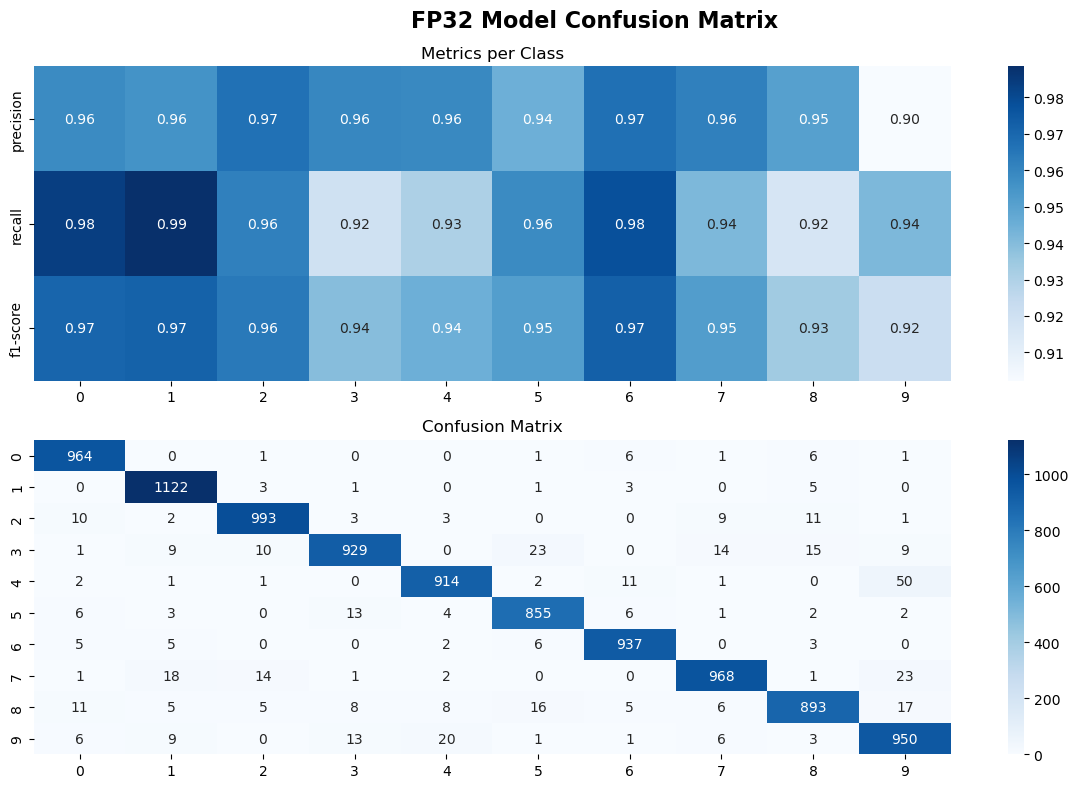

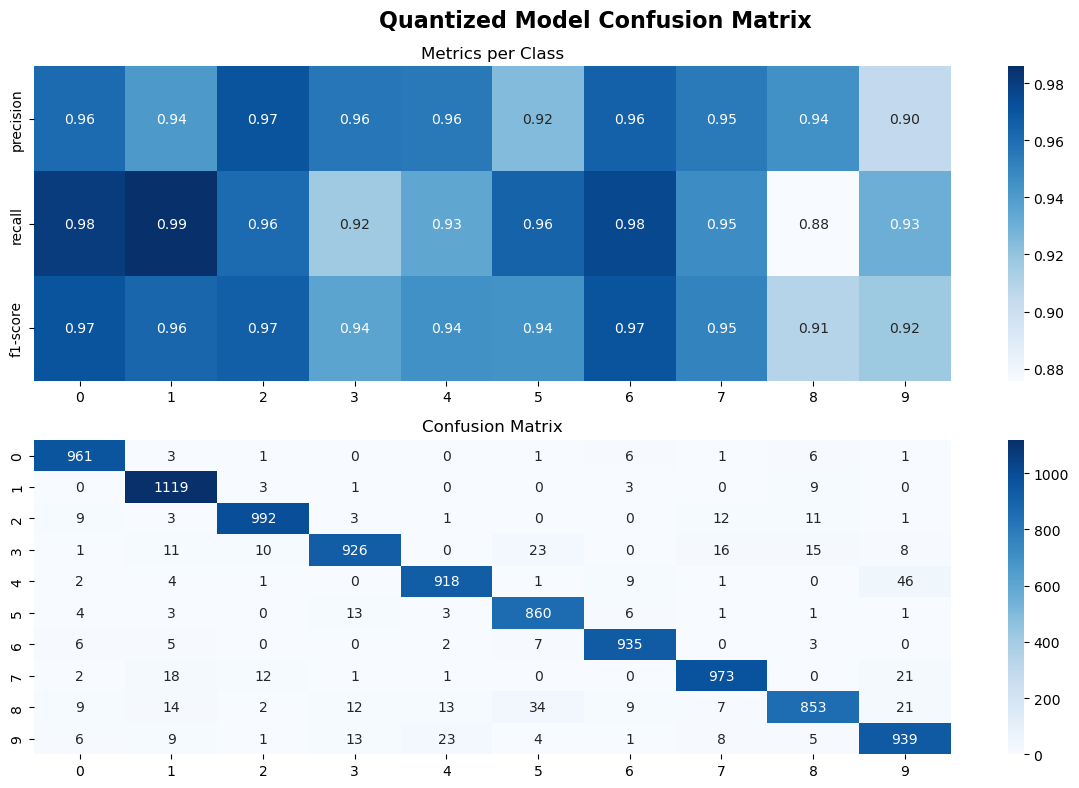

In [48]:
import numpy as np

# For FP32 model
fp32_model.eval()
y_true_fp32 = []
y_pred_fp32 = []

with torch.no_grad():
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        output = fp32_model(data)
        _, predicted = torch.max(output, 1)
        y_true_fp32.extend(target.cpu().numpy())
        y_pred_fp32.extend(predicted.cpu().numpy())
y_true_fp32 = np.array(y_true_fp32)
y_pred_fp32 = np.array(y_pred_fp32)

class_names = [str(i) for i in range(10)]
plot_confusion_matrix(y_true_fp32, y_pred_fp32, class_names, title="FP32 Model Confusion Matrix")

# For quantized model
wrapped_qmodel.eval()
y_true_quant = []
y_pred_quant = []

with torch.no_grad():
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        output = wrapped_qmodel(data)
        _, predicted = torch.max(output, 1)
        y_true_quant.extend(target.cpu().numpy())
        y_pred_quant.extend(predicted.cpu().numpy())
y_true_quant = np.array(y_true_quant)
y_pred_quant = np.array(y_pred_quant)

plot_confusion_matrix(y_true_quant, y_pred_quant, class_names, title="Quantized Model Confusion Matrix")



In [49]:
from sklearn.metrics import classification_report
import pandas as pd

# FP32 model report
report_fp32 = classification_report(y_true_fp32, y_pred_fp32, target_names=class_names, output_dict=True)
df_report_fp32 = pd.DataFrame(report_fp32)
print("FP32 Model Classification Report:")
display(df_report_fp32)

# Quantized model report
report_quant = classification_report(y_true_quant, y_pred_quant, target_names=class_names, output_dict=True)
df_report_quant = pd.DataFrame(report_quant)
print("Quantized Model Classification Report:")
display(df_report_quant)

FP32 Model Classification Report:


,0,1,2,3,4,5,6,7,8,9,accuracy,macro avg,weighted avg
precision,0.958250,0.955707,0.966894,0.959711,0.959077,0.944751,0.966976,0.962227,0.951012,0.902184,0.9525,0.952679,0.952761
recall,0.983673,0.988546,0.962209,0.919802,0.930754,0.958520,0.978079,0.941634,0.916838,0.941526,0.9525,0.952158,0.952500
f1-score,0.970796,0.971849,0.964546,0.939333,0.944703,0.951586,0.972496,0.951819,0.933612,0.921435,0.9525,0.952218,0.952427
support,980.000000,1135.000000,1032.000000,1010.000000,982.000000,892.000000,958.000000,1028.000000,974.000000,1009.000000,0.9525,10000.000000,10000.000000


Quantized Model Classification Report:


,0,1,2,3,4,5,6,7,8,9,accuracy,macro avg,weighted avg
precision,0.961000,0.941127,0.970646,0.955624,0.955255,0.924731,0.964912,0.954858,0.944629,0.904624,0.9476,0.947741,0.947858
recall,0.980612,0.985903,0.961240,0.916832,0.934827,0.964126,0.975992,0.946498,0.875770,0.930624,0.9476,0.947242,0.947600
f1-score,0.970707,0.962995,0.965920,0.935826,0.944931,0.944018,0.970420,0.950660,0.908897,0.917440,0.9476,0.947181,0.947420
support,980.000000,1135.000000,1032.000000,1010.000000,982.000000,892.000000,958.000000,1028.000000,974.000000,1009.000000,0.9476,10000.000000,10000.000000


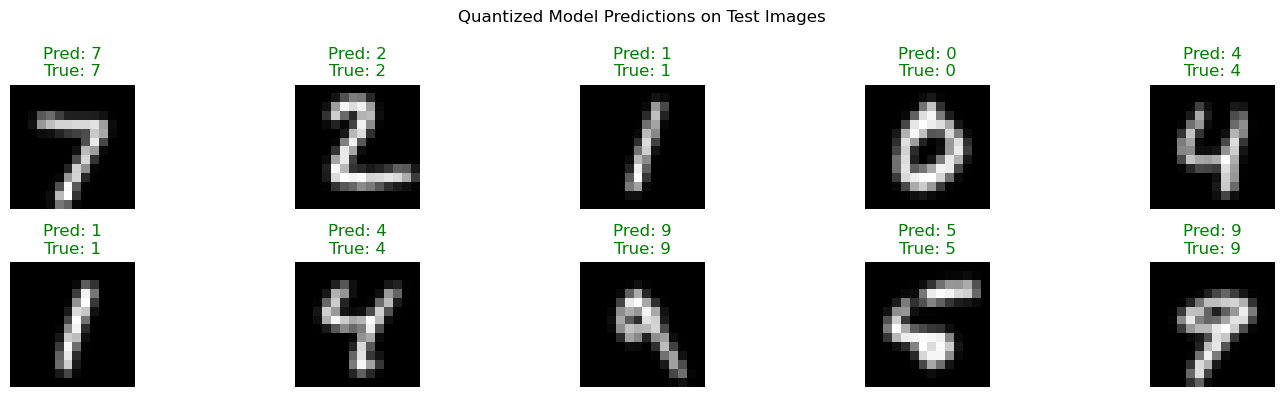

In [50]:
import matplotlib.pyplot as plt

def imshow(img):
    """Display a single image."""
    img = img * 0.3081 + 0.1307  # Unnormalize for MNIST
    npimg = img.numpy()
    plt.imshow(npimg, cmap='gray')
    plt.axis('off')

def show_predictions(model, data_loader, device, num_samples=10):
    """Show model predictions on sample images."""
    model.eval()
    dataiter = iter(data_loader)
    images, labels = next(dataiter)
    
    with torch.no_grad():
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
    
    plt.figure(figsize=(15, 4))
    for i in range(num_samples):
        plt.subplot(2, 5, i + 1)
        imshow(images[i].cpu().squeeze())
        color = 'green' if predicted[i] == labels[i] else 'red'
        plt.title(f'Pred: {predicted[i].item()}\nTrue: {labels[i].item()}', color=color)
    plt.suptitle("Quantized Model Predictions on Test Images")
    plt.tight_layout()
    plt.show()

# Show some predictions for the quantized model
try:
    show_predictions(wrapped_qmodel, val_loader, device)
except Exception as e:
    print(f"Error displaying predictions: {e}")

---
---